In [17]:
import os
import gc
import sys
import glob
import numpy as np
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker
from multiprocessing import Pool
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, OCEAN
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [11]:
# To use PLUMBER2_GPP_common_utils, change directory to where it exists
os.chdir('/g/data/w97/mm3972/scripts/Land_Drought_Rainfall')
from common_utils import *
from spatial_wrf_hgt_var import *

### Compare monthly data

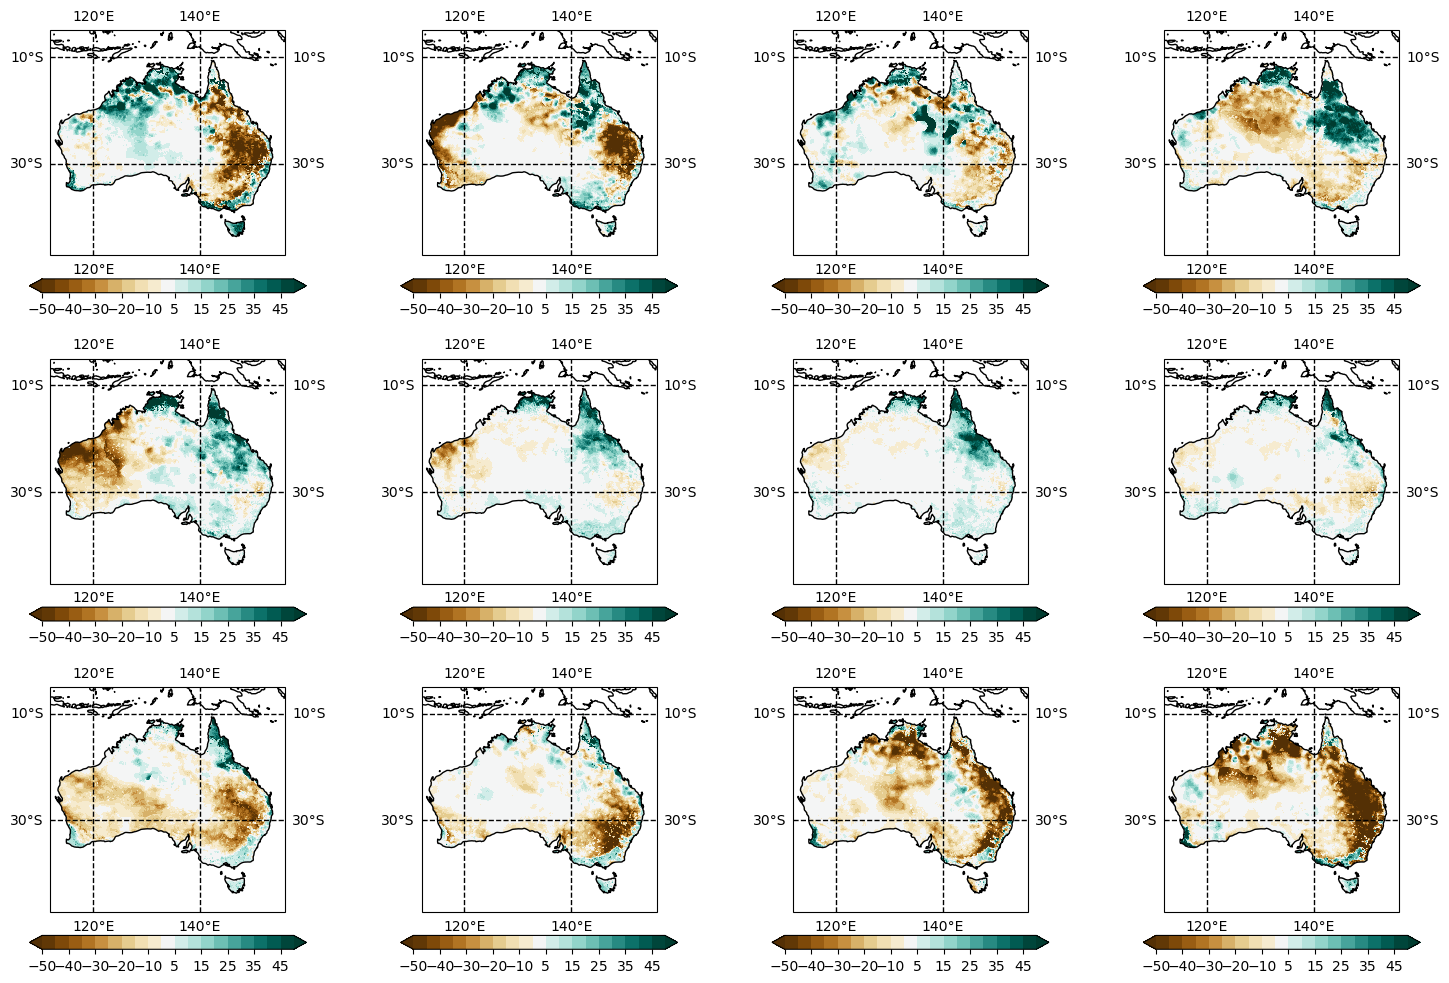

In [18]:
climate_file      = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/spinup_run_1970_1999_GWMoist_reduce_50percent/outputs/cable_out_1970-1999.nc'   
time_varying_path = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/run_2000_2019_GWMoist_reduce_50percent_daily_rst_control/outputs'


dom_common        = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dom_leap          = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for year in np.arange(2019,2020):
    if year % 4 == 0:
        dom = dom_leap
    else:
        dom = dom_common
        
    f_clim          = nc.Dataset(climate_file, mode='r')
    f_time_varying  = nc.Dataset(f'{time_varying_path}/cable_out_{year}.nc', mode='r')
    
    Qle_clim        = f_clim.variables['Qle'][:]
    lat_clim        = f_clim.variables['latitude'][:]
    lon_clim        = f_clim.variables['longitude'][:]
    Qle_time_varying= f_time_varying.variables['Qle'][:]
    
    # Create a figure with 3 subplots in 1 row
    fig, axs        = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Adjust spacing between subplots
    loc_lat = None

    # Flatten axs for consistent iteration
    axs_flat = axs.flatten()

    # Loop through each axis
    for ax in axs_flat:

        # Set extent based on loc_lat and loc_lon
        if loc_lat is None:
            ax.set_extent([112, 156, -45, -5])  # Example extent, adjust as needed
        else:
            ax.set_extent([loc_lon[0], loc_lon[1], loc_lat[0], loc_lat[1]])

        ax.coastlines(resolution="50m", linewidth=1)

        # Add gridlines
        gl               = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', linestyle='--')
        gl.xlabels_top   = False
        gl.ylabels_right = False
        gl.xlines        = True

        if loc_lat is None:
            gl.xlocator = mticker.FixedLocator([120, 140])
            gl.ylocator = mticker.FixedLocator([-10, -30])
        else:
            gl.xlocator = mticker.FixedLocator(loc_lon)
            gl.ylocator = mticker.FixedLocator(loc_lat)

        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Plot windspeed based on variable names

    clevs =  [-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 
                5,  10,  15,  20,  25,  30,  35,  40,  45, 50 ] # np.linspace(-50, 0.2, num=21)

    for i in np.arange(12):
        
        ds         = np.sum(dom[:i+1])
        de         = np.sum(dom[:i+2])
        
        row  = int(i / 4) 
        col  = i % 4
        plot = axs[row, col].contourf(lon_clim, lat_clim, (np.nanmean(Qle_time_varying[ds:de,:,:], axis=0) - Qle_clim[i,:,:]), 
                                      levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
        cb   = plt.colorbar(plot, ax=axs[row, col], orientation="horizontal", pad=0.08, aspect=20, shrink=0.8)
        cb.ax.tick_params(labelsize=10)


    fig.tight_layout()
    plt.savefig(f'./plots/Compare_time_varying_climate_{year}_monthly',dpi=300)
    

### Compare yearly data

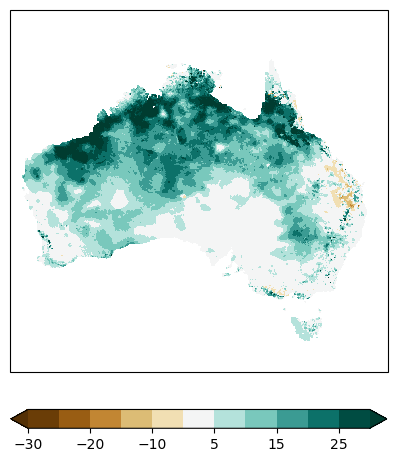

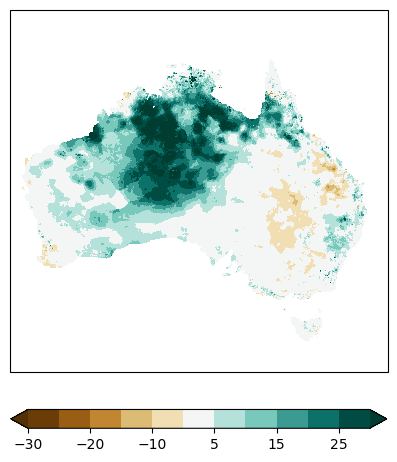

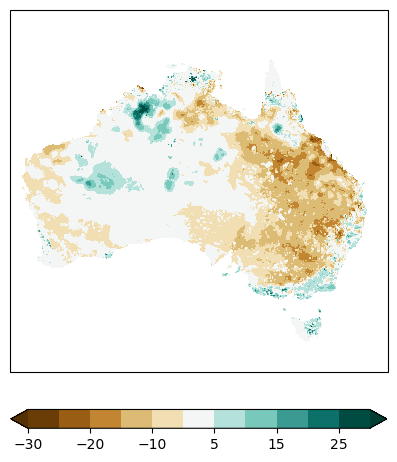

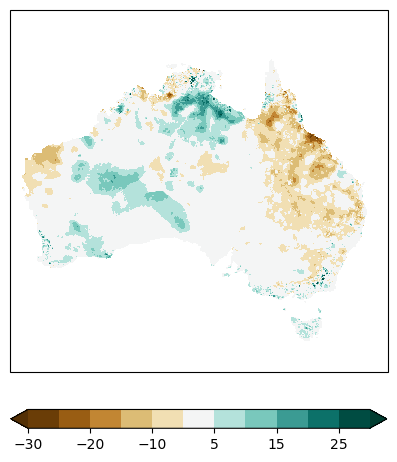

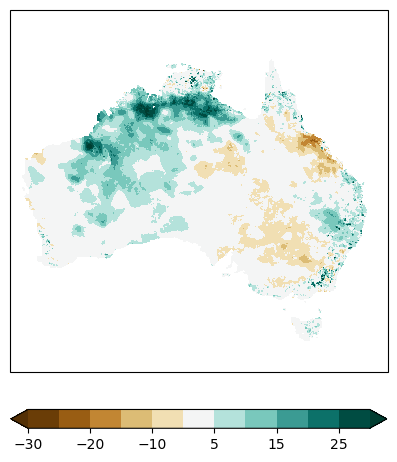

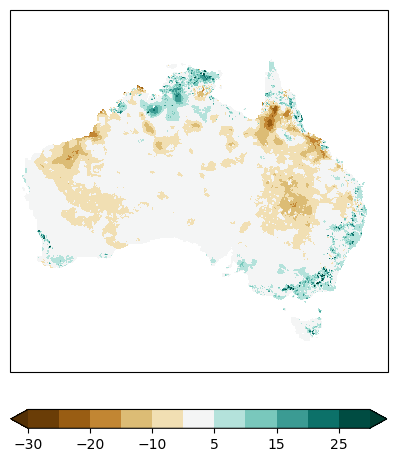

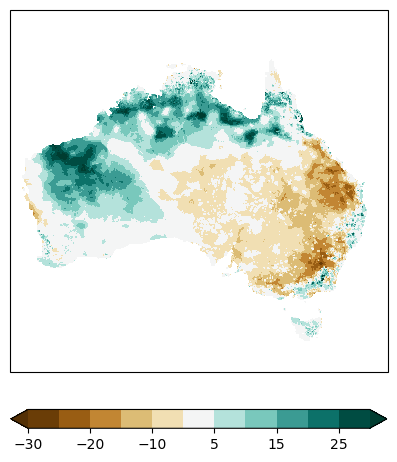

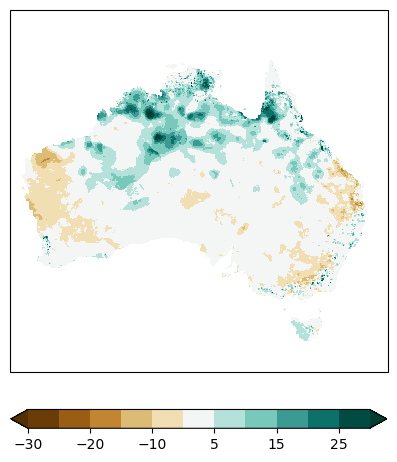

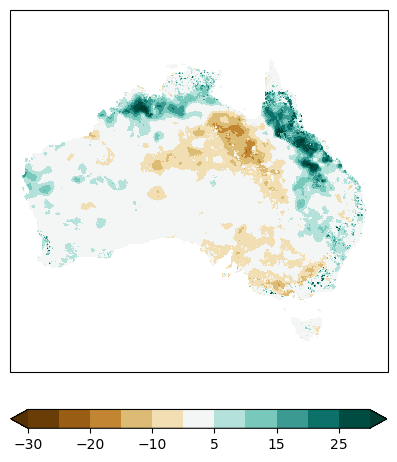

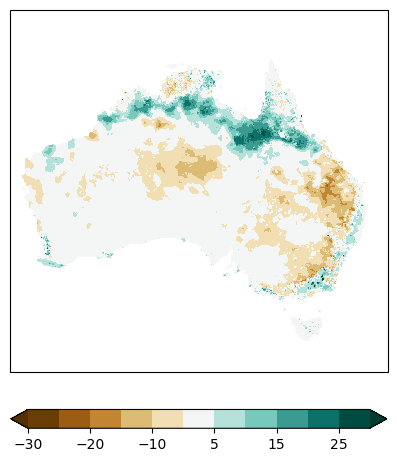

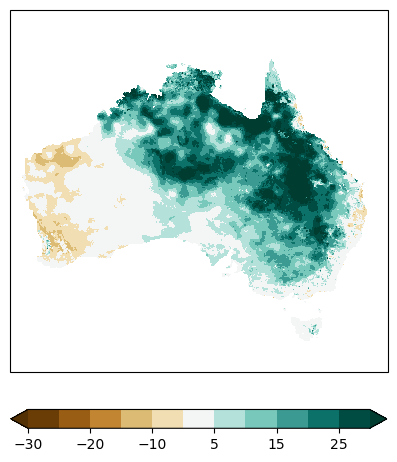

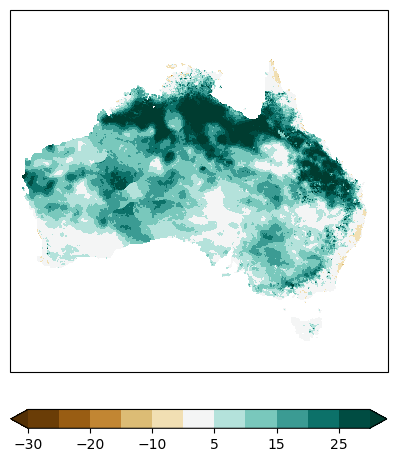

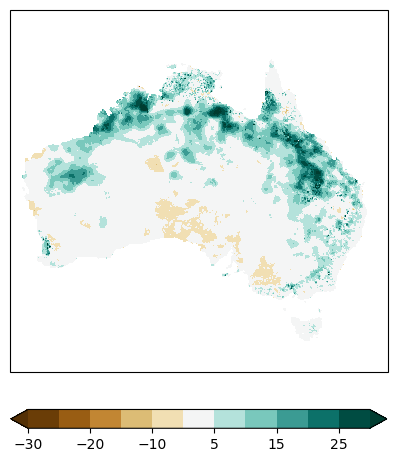

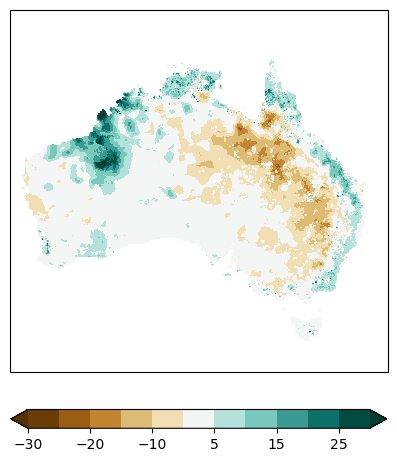

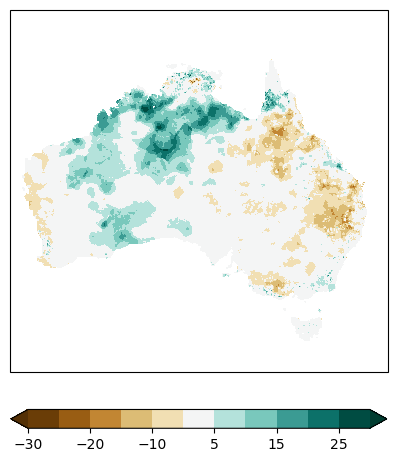

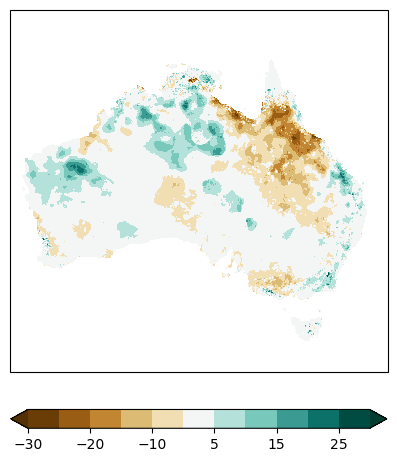

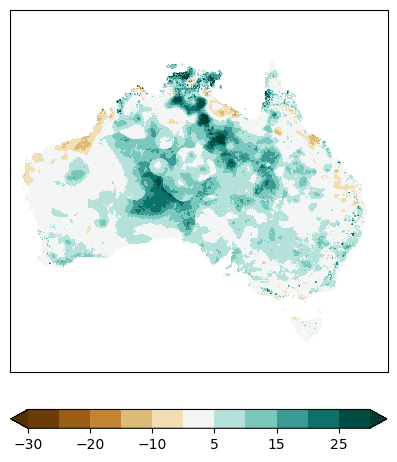

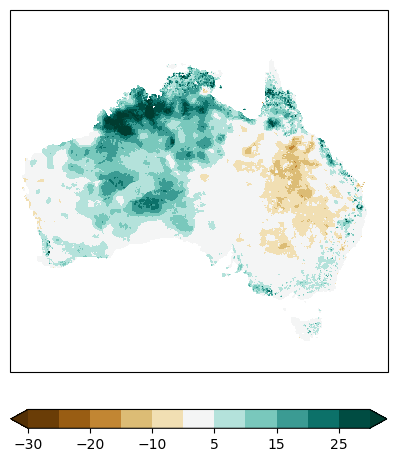

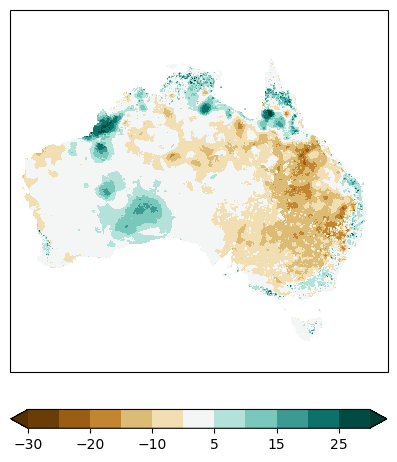

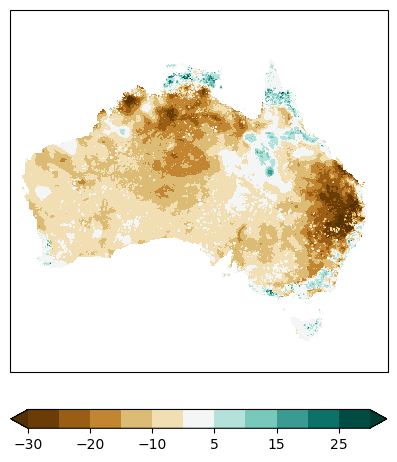

In [8]:
# climate_file      = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/spinup_run_1970_1999_GWMoist_reduce_50percent/outputs/cable_out_1970-1999.nc'   
# time_varying_path = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/run_2000_2019_GWMoist_reduce_50percent_daily_rst_control/outputs'

climate_file      = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/spinup_run_1970_1999/outputs/cable_out_1970-1999.nc'   
time_varying_path = '/scratch/w97/mm3972/model/CABLE/Land_drought_rainfall_runs/run_2000_2019_daily_rst_control/outputs'

for year in np.arange(2000,2020):
    
    f_clim         = nc.Dataset(climate_file, mode='r')
    f_time_varying = nc.Dataset(f'{time_varying_path}/cable_out_{year}.nc', mode='r')
    
    Qle_clim        = np.nanmean(f_clim.variables['Qle'][:], axis=0)
    lat_clim        = f_clim.variables['latitude'][:]
    lon_clim        = f_clim.variables['longitude'][:]
    Qle_time_varying= np.nanmean(f_time_varying.variables['Qle'][:], axis=0)
    
    # Create a figure with 3 subplots in 1 row
    fig, axs        = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set extent based on loc_lat and loc_lon
    axs.set_extent([112, 156, -45, -5])  # Example extent, adjust as needed
    ax.coastlines(resolution="50m", linewidth=1)

    # Add gridlines
    gl               = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', linestyle='--')
    gl.xlabels_top   = False
    gl.ylabels_right = False
    gl.xlines        = True

    gl.xlocator      = mticker.FixedLocator([120, 140])
    gl.ylocator      = mticker.FixedLocator([-10, -30])

    gl.xformatter    = LongitudeFormatter()
    gl.yformatter    = LatitudeFormatter()
    gl.xlabel_style  = {'size': 10, 'color': 'black'}
    gl.ylabel_style  = {'size': 10, 'color': 'black'}

    # Plot windspeed based on variable names

    clevs =  [-30,-25,-20,-15,-10,-5,5,10,15,20,25,30] # np.linspace(-50, 0.2, num=21)


    plot = axs.contourf(lon_clim, lat_clim, Qle_time_varying - Qle_clim, levels=clevs, transform=ccrs.PlateCarree(), extend='both', cmap=plt.cm.BrBG)
    cb   = plt.colorbar(plot, ax=axs, orientation="horizontal", pad=0.08, aspect=20, shrink=0.8)
    cb.ax.tick_params(labelsize=10)


    fig.tight_layout()
    plt.savefig(f'./plots/Compare_time_varying_climate_{year}_yearly_orig',dpi=300)
